### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
## Read Data for Cases, Deaths and Recoveries
confirmed_cases_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [4]:
confirmed_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19


In [5]:
### Melt the dateframe into the right shape and set index
def melt_data(df_raw, drop_country=None):
    df_cleaned = df_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_name='Cases',
                             var_name='Date')
    df_cleaned = df_cleaned.set_index(['Country/Region', 'Province/State', 'Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned


### Get Country-wise Data
def country_wise(df_cleaned, oldname, newname):
    df_country = df_cleaned.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()
    df_country = df_country.set_index(['Country/Region', 'Date'])
    df_country.index = df_country.index.set_levels(
        [df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country = df_country.sort_values(['Country/Region', 'Date'], ascending=True)
    df_country = df_country.rename(columns={oldname: newname})
    return df_country


### Get DailyData from Cumulative sum
def dailydata(dfcountry, oldname, newname):
    dfcountrydaily = dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily = dfcountrydaily.rename(columns={oldname: newname})
    return dfcountrydaily

In [6]:
# Clean all datasets
confirmed_cases = melt_data(confirmed_cases_raw, ['China', 'Mainland China'])
deaths = melt_data(deaths_raw, ['China', 'Mainland China'])
recoveries = melt_data(recoveries_raw, ['China', 'Mainland China'])

In [7]:
confirmed_cases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/20,33.0000,65.0000,0
Albania,NaN,1/22/20,41.1533,20.1683,0
Algeria,NaN,1/22/20,28.0339,1.6596,0
Andorra,NaN,1/22/20,42.5063,1.5218,0
Angola,NaN,1/22/20,-11.2027,17.8739,0


In [8]:
# Get country-wise data
confirmed_cases_country = country_wise(confirmed_cases, 'Cases', 'Total Confirmed Cases')
deaths_country = country_wise(deaths, 'Cases', 'Total Deaths')
recoveries_country = country_wise(recoveries, 'Cases', 'Total Recoveries')

In [9]:
# Get Daily Data
new_cases_country = dailydata(confirmed_cases_country, 'Total Confirmed Cases', 'Daily New Cases')
new_deaths_country = dailydata(deaths_country, 'Total Deaths', 'Daily New Deaths')
new_recoveries_country = dailydata(recoveries_country, 'Total Recoveries', 'Daily New Recoveries')

In [10]:
covid_cases = pd.merge(confirmed_cases_country, new_cases_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, recoveries_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_recoveries_country, how='left', left_index=True, right_index=True)


covid_cases['Active Cases'] = covid_cases['Total Confirmed Cases'] - covid_cases[
    'Total Deaths'] - covid_cases['Total Recoveries']
covid_cases['Share of Recoveries - Closed Cases'] = np.round(covid_cases['Total Recoveries'] / (
        covid_cases['Total Recoveries'] + covid_cases['Total Deaths']), 2)
covid_cases['Death to Cases Ratio'] = np.round(
    covid_cases['Total Deaths'] / covid_cases['Total Confirmed Cases'], 3)


In [11]:
global_totals = covid_cases.reset_index().groupby('Date').sum()
global_totals['Share of Recoveries - Closed Cases'] = np.round(
    global_totals['Total Recoveries'] / (global_totals['Total Recoveries'] + global_totals['Total Deaths']), 2)
global_totals['Death to Cases Ratio'] = np.round(global_totals['Total Deaths'] / global_totals['Total Confirmed Cases'], 3)
global_totals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-04-08,1428295,84917.0,6471.0,85001,251094,28450.0,1092200,0.75,0.060
2020-04-09,1512467,84172.0,7115.0,92116,276296,25202.0,1144055,0.75,0.061


# Plot Global Total Cases

In [12]:
global_totals.iloc[-1]

Total Confirmed Cases                 1512467.000
Daily New Cases                         84172.000
Daily New Deaths                         7115.000
Total Deaths                            92116.000
Total Recoveries                       276296.000
Daily New Recoveries                    25202.000
Active Cases                          1144055.000
Share of Recoveries - Closed Cases          0.750
Death to Cases Ratio                        0.061
Name: 2020-04-09 00:00:00, dtype: float64

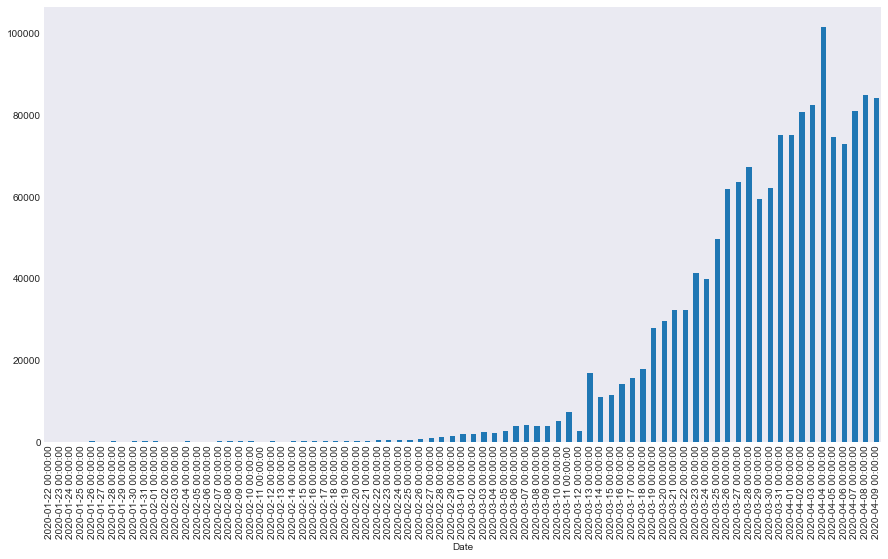

In [13]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['Daily New Cases'].plot.bar()

In [14]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['growth'] = global_totals['Daily New Cases'] / global_totals['Active Cases']

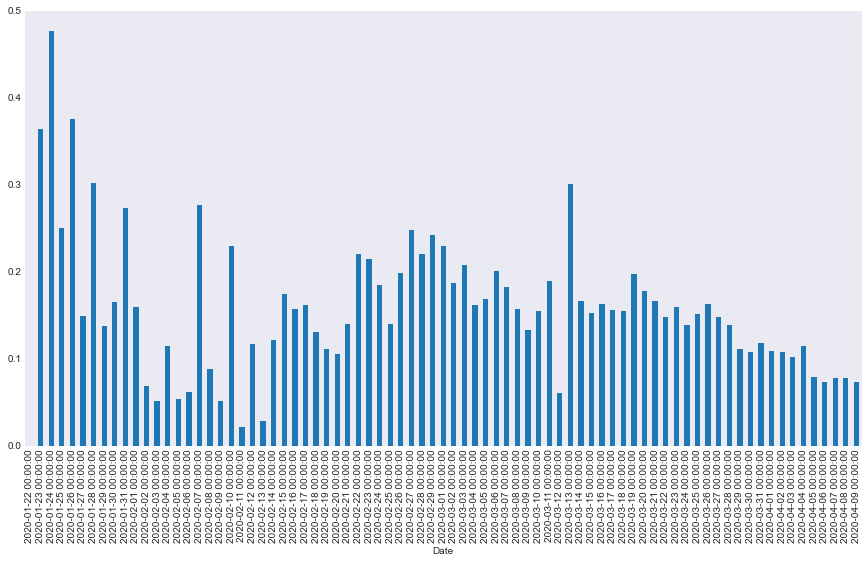

In [15]:
global_totals['growth'].plot.bar()

# Explore Country Specific Data

In [16]:
germany = covid_cases.loc['Germany'].copy()
germany.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-04-05,100123,4031.0,140.0,1584,28700,2300.0,69839,0.95,0.016
2020-04-06,103374,3251.0,226.0,1810,28700,0.0,72864,0.94,0.018
2020-04-07,107663,4289.0,206.0,2016,36081,7381.0,69566,0.95,0.019
2020-04-08,113296,5633.0,333.0,2349,46300,10219.0,64647,0.95,0.021
2020-04-09,118181,4885.0,258.0,2607,52407,6107.0,63167,0.95,0.022


In [17]:
south_korea = covid_cases.loc['Korea, South'].copy()
south_korea.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-04-05,10237,81.0,6.0,183,6463,138.0,3591,0.97,0.018
2020-04-06,10284,47.0,3.0,186,6598,135.0,3500,0.97,0.018
2020-04-07,10331,47.0,6.0,192,6694,96.0,3445,0.97,0.019
2020-04-08,10384,53.0,8.0,200,6776,82.0,3408,0.97,0.019
2020-04-09,10423,39.0,4.0,204,6973,197.0,3246,0.97,0.020


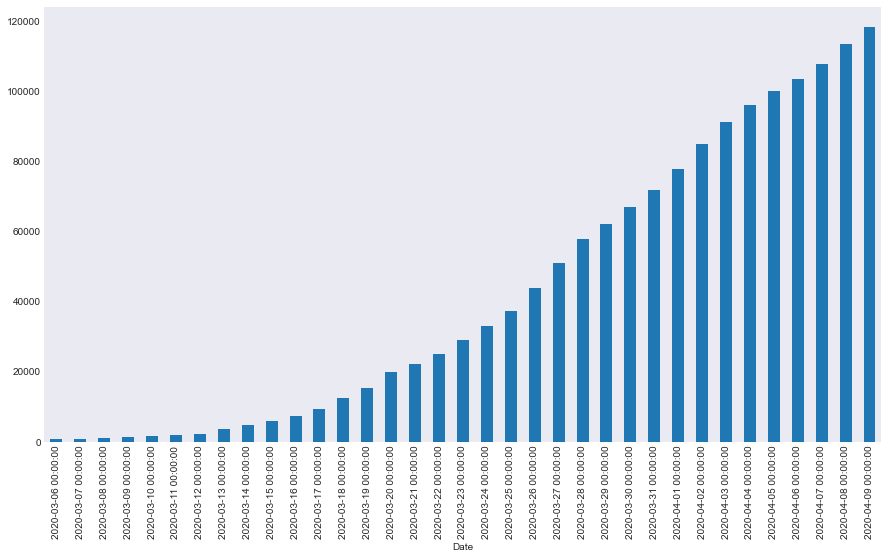

In [18]:
germany['Total Confirmed Cases'].loc['03-06-2020':].plot.bar()

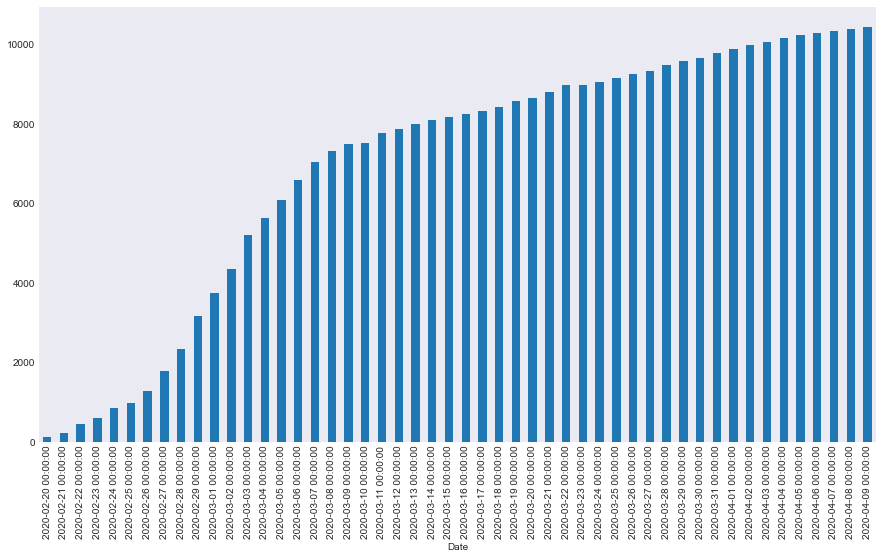

In [19]:
south_korea['Total Confirmed Cases'].loc['02-20-2020':].plot.bar()

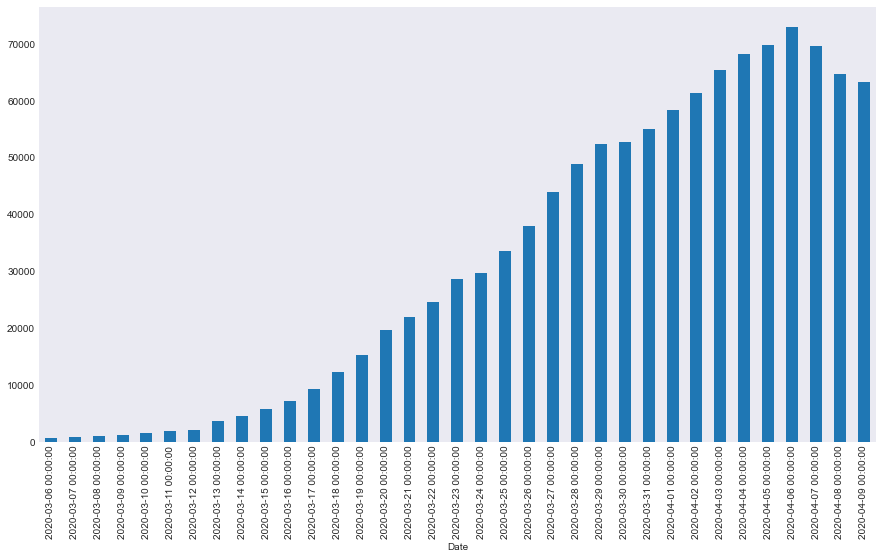

In [20]:
germany['Active Cases'].loc['03-06-2020':].plot.bar()

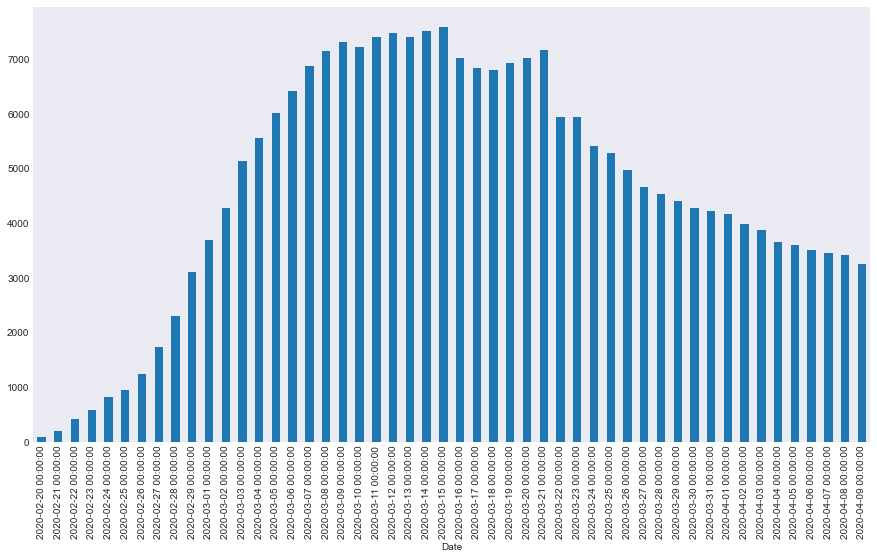

In [21]:
south_korea['Active Cases'].loc['02-20-2020':].plot.bar()

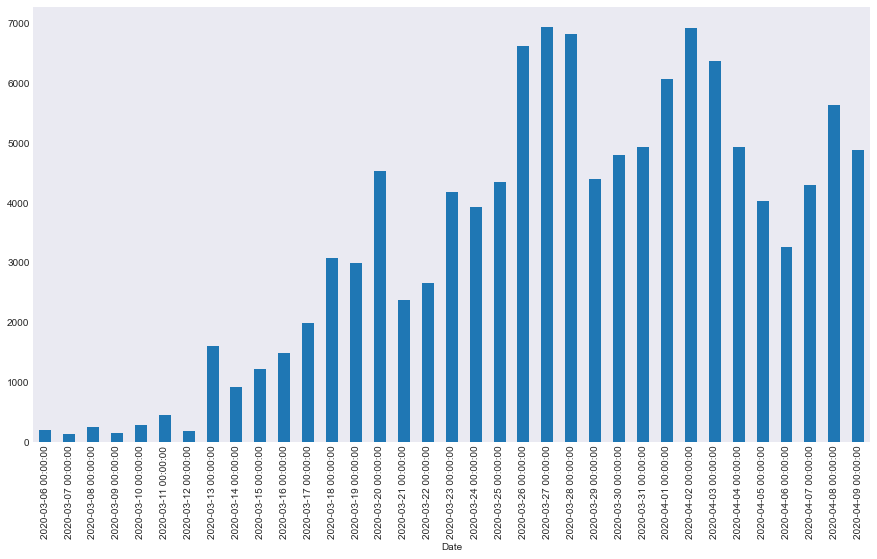

In [22]:
germany['Daily New Cases'].loc['03-06-2020':].plot.bar()

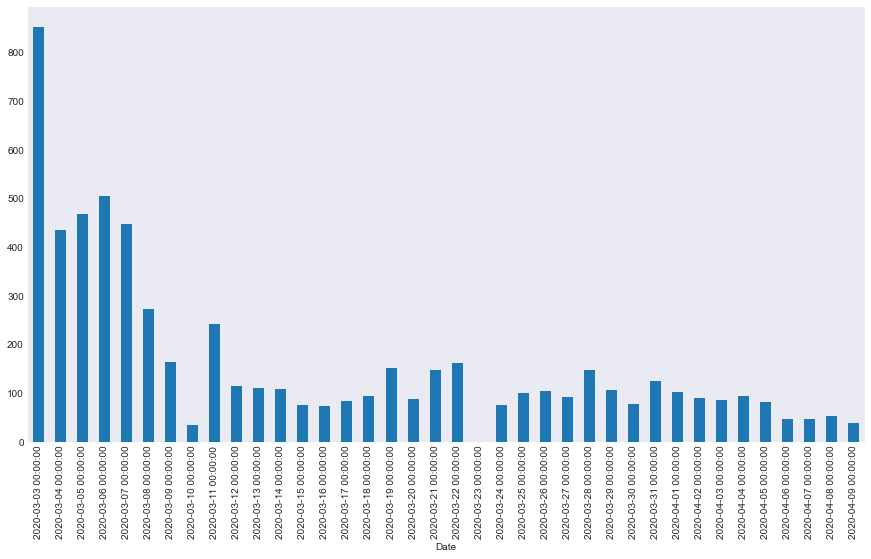

In [23]:
south_korea['Daily New Cases'].iloc[-38:].plot.bar()

In [24]:
germany['growth rate'] = germany['Daily New Cases'] / germany['Active Cases']

In [25]:
start_date = '02-25-2020'
past_window = len(germany) - germany['growth rate'].index.get_loc(start_date)
past_window

45

In [26]:
#past_window = 45

In [27]:
germany_growth_moving_average = germany['growth rate'].iloc[-past_window:].rolling(window=3).mean()
germany_growth_ema = germany['growth rate'].iloc[-past_window:].ewm(span=6,adjust=False).mean()

Text(0.5, 1.0, 'Growth = Daily New Cases / Active Cases')

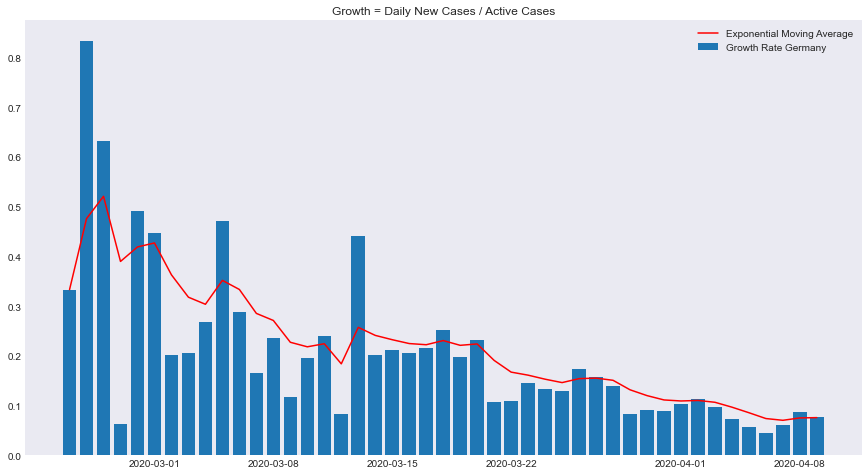

In [28]:
plt.bar(germany.iloc[-past_window:].index, germany['growth rate'].iloc[-past_window:], label='Growth Rate Germany')
#plt.plot(germany_growth_moving_average.index, germany_growth_moving_average, label='Moving Average', color='red')
plt.plot(germany_growth_ema.index, germany_growth_ema, label='Exponential Moving Average', color='red')

plt.legend(loc='best')
plt.title('Growth = Daily New Cases / Active Cases')

In [29]:
germany['growth rate'].tail(10)

Date
2020-03-31    0.089618
2020-04-01    0.104099
2020-04-02    0.113018
2020-04-03    0.097460
2020-04-04    0.072281
2020-04-05    0.057718
2020-04-06    0.044617
2020-04-07    0.061654
2020-04-08    0.087135
2020-04-09    0.077335
Name: growth rate, dtype: float64

In [30]:
south_korea['growth rate'] = south_korea['Daily New Cases'] / south_korea['Active Cases']

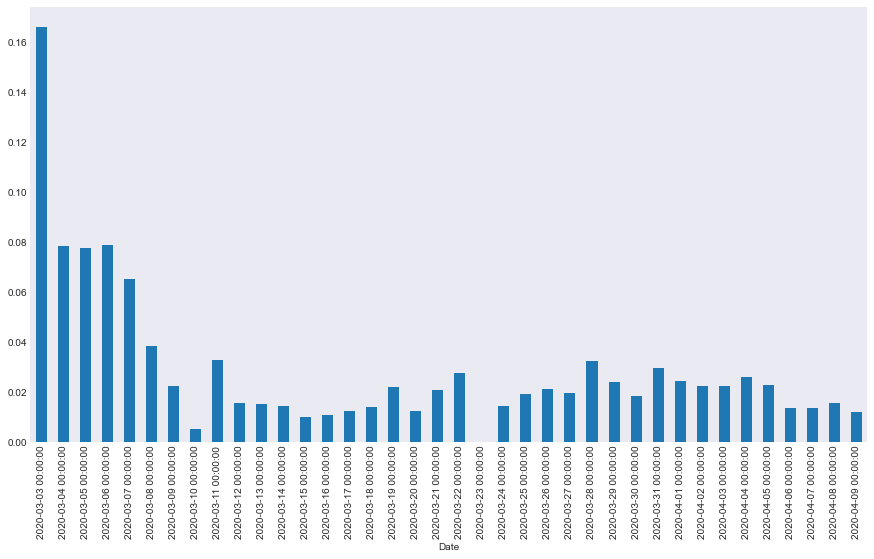

In [31]:
south_korea['growth rate'].iloc[-38:].plot.bar()

In [32]:
south_korea['growth rate'].tail(10)

Date
2020-03-31    0.029649
2020-04-01    0.024308
2020-04-02    0.022367
2020-04-03    0.022239
2020-04-04    0.025725
2020-04-05    0.022556
2020-04-06    0.013429
2020-04-07    0.013643
2020-04-08    0.015552
2020-04-09    0.012015
Name: growth rate, dtype: float64